In [1]:
pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199773 sha256=0e1b47e1a8d58c9a5c9c1e77c8d6c851fa84b5ba0d96c0c9c40cf90f8efe2638
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [3]:
import fasttext
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [26]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Input ,LSTM, Dropout,Flatten,Bidirectional, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping

In [5]:
# os.chdir('/Users/nikhilkudupudi/Projects - School & Work/FAI /Project/Tweet-Classification-for-Disaster-Detection/data')
# print(os.getcwd())

# df = pd.read_csv('train.csv')
# df.head()

# Loading the dataset
drive.mount('/content/drive')
df_train = pd.read_csv('/content/drive/MyDrive/train.csv')
# df_test = pd.read_csv('/content/drive/MyDrive/test.csv')
df_train.head()

Mounted at /content/drive


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df = df_train[['text','target']]
df.head(2)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1


In [7]:
# Define the emoji pattern
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

# stop_words = set(stopwords.words('english'))

def clean_text(text):

    # Expand contractions
    text = re.sub(r"can\'t", "cannot", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'ll", " will", text)

    # Remove email address, urls and links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text, flags=re.MULTILINE)

    text = re.sub(r'@\S+', '', text) #Remove words that starts with @ (i.e tweets that start with @ are mostly username that got tagged)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    text = re.sub(r'\s+', ' ', text) #Remove consecutive whitespace characters

    # Convert to lowercase
    text = text.lower().strip()

    # Remove Emoji
    text = emoji_pattern.sub(r'', text)

    # Tokenization and stopwords removal
    # tokens = word_tokenize(text)
    # filtered_tokens = [token for token in tokens if token not in stop_words]

    # # Part-of-speech tagging
    # pos_tagged = nltk.pos_tag(filtered_tokens)

    # # Lemmatization
    # lemmatized_text = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tagged]

    return text.strip()

In [8]:
# Cleaning the text column in the dataset
df['clean_txt_without_stopwords'] = df['text'].apply(clean_text)

<ipython-input-8-60a271a78e6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_txt_without_stopwords'] = df['text'].apply(clean_text)


In [9]:
df[df.duplicated(subset = ['clean_txt_without_stopwords'])]['target'].value_counts()
# duplicates with target

1    475
0    321
Name: target, dtype: int64

In [ ]:
df[df.duplicated(subset = ['clean_txt_without_stopwords','target'])]['target'].value_counts()
# duplicates without target

1    437
0    276
Name: target, dtype: int64

In [ ]:
# removing the duplicates
df = df.drop_duplicates(subset = ['clean_txt_without_stopwords','target'], keep = 'first')

In [ ]:
df = df.reset_index(drop = True)
df

,text,target,clean_txt_without_stopwords
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in ...
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...
...,...,...,...
6895,#breaking #LA Refugio oil spill may have been ...,1,breaking la refugio oil spill may have been co...
6896,a siren just went off and it wasn't the Forney...,1,a siren just went off and it was not the forne...
6897,Officials say a quarantine is in place at an A...,1,officials say a quarantine is in place at an a...
6898,on the flip side I'm at Walmart and there is a...,1,on the flip side im at walmart and there is a ...


# Text Correction and checking

In [ ]:
df[df['clean_txt_without_stopwords'].str.match(re.compile(r'check these out'))]

,text,target,clean_txt_without_stopwords
40,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,check these out nsfw
48,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,check these out nsfw


In [ ]:
df[df['clean_txt_without_stopwords'].str.match(re.compile(r'check these out'))]['text'][40]

'Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw'

In [ ]:
df[df['clean_txt_without_stopwords'].str.match(re.compile(r'check these out'))]['clean_txt_without_stopwords'][40]

'check these out nsfw'

In [ ]:
df[df['text'].str.contains(re.compile(r'@'))]

,text,target,clean_txt_without_stopwords
31,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,wholesale markets ablaze
36,@PhDSquares #mufc they've built so much hype a...,0,mufc they have built so much hype around new a...
43,SOOOO PUMPED FOR ABLAZE ???? @southridgelife,0,soooo pumped for ablaze
54,Noches El-Bestia '@Alexis_Sanchez: happy to se...,0,noches elbestia happy to see my teammates and ...
57,Set our hearts ablaze and every city was a gif...,0,set our hearts ablaze and every city was a gif...
...,...,...,...
7577,@widda16 ... He's gone. You can relax. I thoug...,0,hes gone you can relax i thought the wife who ...
7578,@jt_ruff23 @cameronhacker and I wrecked you both,0,and i wrecked you both
7581,@engineshed Great atmosphere at the British Li...,0,great atmosphere at the british lion gig tonig...
7596,RT @LivingSafely: #NWS issues Severe #Thunders...,1,rt nws issues severe thunderstorm warnings for...


In [ ]:
df[df['text'].str.contains(re.compile(r'@'))]['text'][63]

"@Navista7 Steve these fires out here are something else! California is a tinderbox - and this clown was setting my 'hood ablaze @News24680"

In [ ]:
df[df['text'].str.contains(re.compile(r'@'))]['clean_txt_without_stopwords'][63]

'steve these fires out here are something else california is a tinderbox and this clown was setting my hood ablaze'

In [ ]:
df[df['text'].str.contains(re.compile(r'-'))]

,text,target,clean_txt_without_stopwords
5,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire update california hwy closed in both...
11,Haha South Tampa is getting flooded hah- WAIT ...,1,haha south tampa is getting flooded hah wait a...
37,INEC Office in Abia Set Ablaze - http://t.co/3...,1,inec office in abia set ablaze
52,SANTA CRUZ ÛÓ Head of the St Elizabeth Police...,0,santa cruz head of the st elizabeth police sup...
54,Noches El-Bestia '@Alexis_Sanchez: happy to se...,0,noches elbestia happy to see my teammates and ...
...,...,...,...
7598,Father-of-three Lost Control of Car After Over...,1,fatherofthree lost control of car after overta...
7606,Suicide bomber kills 15 in Saudi security site...,1,suicide bomber kills in saudi security site mo...
7607,#stormchase Violent Record Breaking EF-5 El Re...,1,stormchase violent record breaking ef el reno ...
7611,Police investigating after an e-bike collided ...,1,police investigating after an ebike collided w...


In [ ]:
df[df['text'].str.contains(re.compile(r'-'))]['text'][5]

'#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'

In [ ]:
df[df['text'].str.contains(re.compile(r'-'))]['clean_txt_without_stopwords'][5]

'rockyfire update california hwy closed in both directions due to lake county fire cafire wildfires'

# Saving the code file and working on the embeddings part

In [ ]:
# df['clean_txt_without_stopwords'].to_csv('/Users/nikhilkudupudi/Projects - School & Work/FAI /Project/cleaned_tweets_with_stopwords.txt', sep='\t',header = False, index = False)

# Embeddings with 2-Dim

In [ ]:
tweet_embeddings = fasttext.train_unsupervised('/content/drive/MyDrive/cleaned_tweets_with_stopwords.txt',epoch = 10, dim = 50)

In [ ]:
tweet_embeddings.get_nearest_neighbors('ablaze')

[(0.901380181312561, 'jeb'),
 (0.8840951323509216, 'blaze'),
 (0.883853554725647, 'burns'),
 (0.8807284235954285, 'add'),
 (0.8800090551376343, 'burst'),
 (0.8709315061569214, 'view'),
 (0.8685218095779419, 'doubt'),
 (0.8675563931465149, 'scene'),
 (0.8571450710296631, 'rocky'),
 (0.8559867143630981, 'solar')]

In [ ]:
def embed_tweet(text):
    text_list = word_tokenize(text)

    return np.mean([tweet_embeddings.get_word_vector(token) for token in text_list], axis=0)

In [ ]:
def get_embedding_array(df):
    embeddings_array = []
    for i in range(len(df)):
        embeddings_array.append(embed_tweet(df['clean_txt_without_stopwords'][i]))

    return np.array(embeddings_array)

In [ ]:
embeddings_array = get_embedding_array(df)

In [ ]:
embeddings_array.shape

(7613, 50)

In [ ]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(embeddings_array, df_train['target'], test_size=0.2, random_state=42)

# Display the shapes of the output vectors
x_train.shape, x_val.shape

((6090, 50), (1523, 50))

## RNN model building

In [ ]:
model_2d = Sequential()

model_2d.add(LSTM(64, return_sequences = True, input_shape = (50,1)))
model_2d.add(Dropout(0.2))
model_2d.add(LSTM(128, return_sequences = True))
model_2d.add(Dropout(0.2))
model_2d.add(LSTM(128, return_sequences = True))
model_2d.add(Dropout(0.2))
model_2d.add(LSTM(128, return_sequences = True))
model_2d.add(Dropout(0.2))
model_2d.add(LSTM(64))
model_2d.add(Dropout(0.2))

model_2d.add(Flatten())

model_2d.add(Dense(128, activation = 'relu'))
model_2d.add(Dropout(0.2))
model_2d.add(Dense(34, activation = 'relu'))
model_2d.add(Dropout(0.2))
model_2d.add(Dense(32, activation = 'relu'))
model_2d.add(Dropout(0.2))
model_2d.add(Dense(1, activation='sigmoid'))

model_2d.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 50, 64)            16896     
                                                                 
 dropout_19 (Dropout)        (None, 50, 64)            0         
                                                                 
 lstm_14 (LSTM)              (None, 50, 128)           98816     
                                                                 
 dropout_20 (Dropout)        (None, 50, 128)           0         
                                                                 
 lstm_15 (LSTM)              (None, 50, 128)           131584    
                                                                 
 dropout_21 (Dropout)        (None, 50, 128)           0         
                                                                 
 lstm_16 (LSTM)              (None, 50, 128)          

In [ ]:
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()

def f1_score(y_true, y_pred, precision, recall):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)

    f1 = 2 * (precision_value * recall_value) / (precision_value + recall_value + K.epsilon())
    return f1

@tf.function
def compiled_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, precision_metric, recall_metric)

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_val  = x_val.reshape(x_val.shape[0],x_val.shape[1],1)

x_train.shape,x_val.shape

((6090, 50, 1), (1523, 50, 1))

In [ ]:
model_2d.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=[compiled_f1_score, 'accuracy'])
model_2d.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=( x_val, y_val))

# Embeddings with 3-Dim

In [ ]:
def embed_tweet_3D(embed_model,text):
    text_list = word_tokenize(text)
    sentence_embeddings = [embed_model.get_word_vector(token) for token in text_list]

    return np.array(sentence_embeddings)

In [ ]:
embeddings_dic = {}
for row in range(df.shape[0]):
    embeddings_dic[row] = embed_tweet_3D(tweet_embeddings, df['clean_txt_without_stopwords'][row])

In [ ]:
embeddings_dic[0].shape

(13, 50)

longest Tweet 31


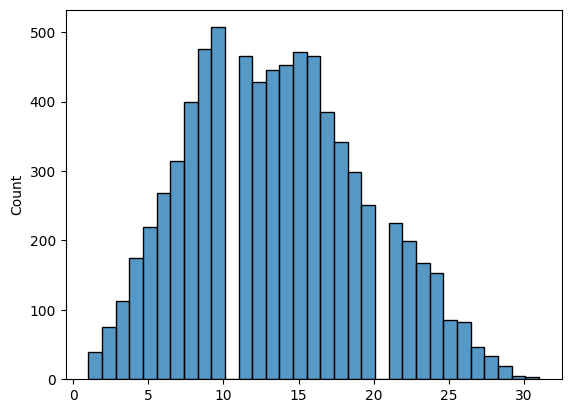

In [ ]:
# we cacnnot convert the dictionary values into array bcoz of the varing length on the tweets.
# to tackle this issue we will do the padding with zeros

tweet_lengths = []
for values in embeddings_dic.values():
  tweet_lengths.append(len(values))

print('longest Tweet',max(tweet_lengths))
max_len = max(tweet_lengths)
tweet_lengths = np.array(tweet_lengths)


sns.histplot(tweet_lengths)
plt.show()

In [ ]:
for key in embeddings_dic.keys():
    len_difference = max_len - len(embeddings_dic[key])

    pad = np.zeros(shape = (len_difference,50)) #50 bcoz for the size of each word vector is 100

    embeddings_dic[key] = np.concatenate([embeddings_dic[key], pad])

In [ ]:
embeddings = np.array(list(embeddings_dic.values()))

In [ ]:
embeddings.shape

(7613, 31, 50)

## RNN model for 3D embeddings

In [ ]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(embeddings, df_train['target'], test_size=0.2, random_state=42)

# Display the shapes of the output vectors
x_train.shape, x_val.shape

((6090, 31, 50), (1523, 31, 50))

In [ ]:
model_3d = Sequential()

model_3d.add(LSTM(64, return_sequences = True, input_shape = (31,50)))
model_3d.add(Dropout(0.2))
model_3d.add(LSTM(128, return_sequences = True))
model_3d.add(Dropout(0.2))
model_3d.add(LSTM(128, return_sequences = True))
model_3d.add(Dropout(0.2))
model_3d.add(LSTM(128, return_sequences = True))
model_3d.add(Dropout(0.2))
model_3d.add(LSTM(64))
model_3d.add(Dropout(0.2))

model_3d.add(Flatten())

model_3d.add(Dense(128, activation = 'relu'))
model_3d.add(Dropout(0.2))
model_3d.add(Dense(34, activation = 'relu'))
model_3d.add(Dropout(0.2))
model_3d.add(Dense(32, activation = 'relu'))
model_3d.add(Dropout(0.2))
model_3d.add(Dense(1, activation='sigmoid'))

model_3d.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 31, 64)            29440     
                                                                 
 dropout_27 (Dropout)        (None, 31, 64)            0         
                                                                 
 lstm_19 (LSTM)              (None, 31, 128)           98816     
                                                                 
 dropout_28 (Dropout)        (None, 31, 128)           0         
                                                                 
 lstm_20 (LSTM)              (None, 31, 128)           131584    
                                                                 
 dropout_29 (Dropout)        (None, 31, 128)           0         
                                                                 
 lstm_21 (LSTM)              (None, 31, 128)          

In [ ]:
model_3d.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=[compiled_f1_score, 'accuracy'])
model_3d.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=( x_val, y_val))

Epoch 1/50
191/191 [==============================] - 15s 27ms/step - loss: 0.5575 - compiled_f1_score: 0.7055 - accuracy: 0.7378 - val_loss: 0.4953 - val_compiled_f1_score: 0.7054 - val_accuracy: 0.7814
Epoch 2/50
191/191 [==============================] - 3s 17ms/step - loss: 0.5161 - compiled_f1_score: 0.7054 - accuracy: 0.7708 - val_loss: 0.4903 - val_compiled_f1_score: 0.7054 - val_accuracy: 0.7754
Epoch 3/50
191/191 [==============================] - 4s 23ms/step - loss: 0.5062 - compiled_f1_score: 0.7053 - accuracy: 0.7734 - val_loss: 0.4790 - val_compiled_f1_score: 0.7054 - val_accuracy: 0.7794
Epoch 4/50
191/191 [==============================] - 4s 21ms/step - loss: 0.4959 - compiled_f1_score: 0.7054 - accuracy: 0.7767 - val_loss: 0.4801 - val_compiled_f1_score: 0.7054 - val_accuracy: 0.7919
Epoch 5/50
191/191 [==============================] - 3s 17ms/step - loss: 0.4802 - compiled_f1_score: 0.7056 - accuracy: 0.7837 - val_loss: 0.4887 - val_compiled_f1_score: 0.7057 - val_a

KeyboardInterrupt: ignored

# Using Glove

In [10]:
pip install gensim

In [12]:
from gensim.models import KeyedVectors
import re

# Specify the path to the GloVe file
glove_file_path = '/content/drive/MyDrive/glove.twitter.27B.100d.txt'

# Load the GloVe model, skipping lines with special tokens
Glove = KeyedVectors.load_word2vec_format(glove_file_path, binary=False, encoding='utf-8', unicode_errors='ignore', no_header=True)

In [13]:
Glove.most_similar('in')

[('of', 0.8025533556938171),
 ('the', 0.7975635528564453),
 ('over', 0.7943724393844604),
 ('is', 0.7938444018363953),
 ('all', 0.7938197255134583),
 ('from', 0.7840762734413147),
 ("'s", 0.7795885801315308),
 ('out', 0.779305636882782),
 ('was', 0.7757747769355774),
 ('there', 0.7664246559143066)]

In [ ]:
type(Glove)

gensim.models.keyedvectors.KeyedVectors

In [ ]:
# from gensim.models import KeyedVectors

# #pretrained model on tweets from stanford - 'https://nlp.stanford.edu/projects/glove/'
# Glove = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/glove.twitter.27B.200d.txt', binary=False)

In [14]:
def glove_embed(text):

    text_list = word_tokenize(text)

    sentence_embeddings = []

    for token in text_list:

      try:
        sentence_embeddings.append(Glove[token])

      except:
        continue

    return np.array(sentence_embeddings)

In [15]:
embeddings_dic = {}
for row in range(df.shape[0]):
    embeddings_dic[row] = glove_embed(df['clean_txt_without_stopwords'][row])

longest Tweet 31


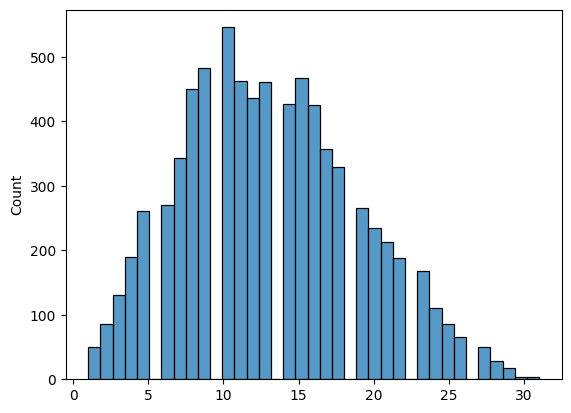

In [16]:
# we cacnnot convert the dictionary values into array bcoz of the varing length on the tweets.
# to tackle this issue we will do the padding with zeros

tweet_lengths = []
for values in embeddings_dic.values():
  tweet_lengths.append(len(values))

print('longest Tweet',max(tweet_lengths))
max_len = max(tweet_lengths)
tweet_lengths = np.array(tweet_lengths)


sns.histplot(tweet_lengths)
plt.show()

In [17]:
for key in embeddings_dic.keys():
    len_difference = max_len - embeddings_dic[key].shape[0]

    pad = np.zeros(shape = (len_difference,100)) #200 bcoz for the size of each word vector is 200

    embeddings_dic[key] = np.concatenate([embeddings_dic[key], pad])

In [18]:
glove_embeddins_array = list(embeddings_dic.values())
glove_embeddins_array = np.array(glove_embeddins_array)

glove_embeddins_array.shape

(7613, 31, 100)

## LSTM model for Glove embeddings

In [19]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(glove_embeddins_array, df['target'], test_size=0.2, random_state=42)

# Display the shapes of the output vectors
x_train.shape, x_val.shape

((6090, 31, 100), (1523, 31, 100))

In [20]:
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()

def f1_score(y_true, y_pred, precision, recall):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)

    f1 = 2 * (precision_value * recall_value) / (precision_value + recall_value + K.epsilon())
    return f1

@tf.function
def compiled_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, precision_metric, recall_metric)

In [46]:
# model_3d_100v = Sequential()

# model_3d.add(LSTM(128, return_sequences = True, input_shape = (31,200)))
# model_3d.add(Dropout(0.2))
# model_3d.add(LSTM(128, return_sequences = True))
# model_3d.add(Dropout(0.2))
# model_3d.add(LSTM(128, return_sequences = True))
# model_3d.add(Dropout(0.2))
# model_3d.add(LSTM(128, return_sequences = True))
# model_3d.add(Dropout(0.2))
# model_3d.add(LSTM(128, return_sequences = True))
# model_3d.add(Dropout(0.2))

# model_3d.add(Flatten())

# model_3d.add(Dense(128, activation = 'relu'))
# model_3d.add(Dropout(0.2))
# model_3d.add(Dense(32, activation = 'relu'))
# model_3d.add(Dropout(0.2))
# model_3d.add(Dense(1, activation='sigmoid'))

# model_3d.summary()


model_3d_100v = Sequential()

model_3d_100v.add(Bidirectional(LSTM(128, return_sequences = True), input_shape = (31,100)))
model_3d_100v.add(BatchNormalization())
model_3d_100v.add(Dropout(0.2))

model_3d_100v.add(Bidirectional(LSTM(256, return_sequences = True)))
model_3d_100v.add(BatchNormalization())
model_3d_100v.add(Dropout(0.2))

model_3d_100v.add(Bidirectional(LSTM(512,return_sequences = True)))
model_3d_100v.add(BatchNormalization())
model_3d_100v.add(Dropout(0.2))

model_3d_100v.add(Bidirectional(LSTM(256,return_sequences = True)))
model_3d_100v.add(BatchNormalization())
model_3d_100v.add(Dropout(0.2))

model_3d_100v.add(LSTM(128))
model_3d_100v.add(BatchNormalization())
model_3d_100v.add(Dropout(0.2))

model_3d_100v.add(Flatten())

model_3d_100v.add(Dense(128, activation = 'relu'))
model_3d_100v.add(BatchNormalization())
model_3d_100v.add(Dropout(0.2))

model_3d_100v.add(Dense(64, activation = 'relu'))
model_3d_100v.add(BatchNormalization())
model_3d_100v.add(Dropout(0.2))

model_3d_100v.add(Dense(32, activation = 'relu'))
model_3d_100v.add(Dropout(0.2))
model_3d_100v.add(Dense(1, activation='sigmoid'))

early_stopping = EarlyStopping(monitor='val_compiled_f1_score', patience=5)

model_3d_100v.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirect  (None, 31, 256)           234496    
 ional)                                                          
                                                                 
 batch_normalization_12 (Ba  (None, 31, 256)           1024      
 tchNormalization)                                               
                                                                 
 dropout_18 (Dropout)        (None, 31, 256)           0         
                                                                 
 bidirectional_11 (Bidirect  (None, 31, 512)           1050624   
 ional)                                                          
                                                                 
 batch_normalization_13 (Ba  (None, 31, 512)           2048      
 tchNormalization)                                    

In [48]:
# as the data is imbalance, we give more weightage to class 1

freq = df['target'].value_counts()
print(freq)

weights = {0: freq.sum()/freq[0], 1: freq.sum()/freq[1] }
print(weights)

0    4342
1    3271
Name: target, dtype: int64
{0: 1.753339474896361, 1: 2.3274228064811986}


In [49]:
model_3d_100v.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=[compiled_f1_score, 'accuracy'])
model_3d_100v.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=( x_val, y_val), class_weight = weights)

Epoch 1/50
191/191 [==============================] - 43s 99ms/step - loss: 1.2859 - compiled_f1_score: 0.8053 - accuracy: 0.6680 - val_loss: 0.5021 - val_compiled_f1_score: 0.8037 - val_accuracy: 0.7932
Epoch 2/50
191/191 [==============================] - 12s 63ms/step - loss: 1.0841 - compiled_f1_score: 0.8026 - accuracy: 0.7509 - val_loss: 0.5156 - val_compiled_f1_score: 0.8016 - val_accuracy: 0.7932
Epoch 3/50
191/191 [==============================] - 8s 41ms/step - loss: 1.0403 - compiled_f1_score: 0.8006 - accuracy: 0.7675 - val_loss: 0.6221 - val_compiled_f1_score: 0.7995 - val_accuracy: 0.6231
Epoch 4/50
191/191 [==============================] - 9s 49ms/step - loss: 1.0096 - compiled_f1_score: 0.7985 - accuracy: 0.7680 - val_loss: 0.5311 - val_compiled_f1_score: 0.7979 - val_accuracy: 0.7971
Epoch 5/50
191/191 [==============================] - 10s 51ms/step - loss: 0.9988 - compiled_f1_score: 0.7972 - accuracy: 0.7823 - val_loss: 0.5942 - val_compiled_f1_score: 0.7964 - val

KeyboardInterrupt: ignored

In [50]:
y_pred = model_3d_100v.predict(x_val)
y_pred = (y_pred > 0.5).astype(int)

48/48 [==============================] - 3s 15ms/step


[[709 165]
 [153 496]]


<Axes: >

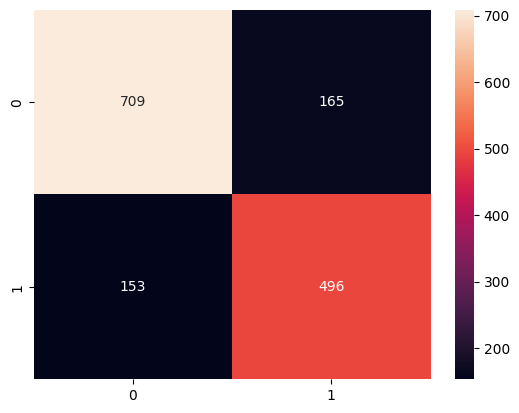

In [51]:
print(confusion_matrix(y_val,y_pred.flatten()))
sns.heatmap(confusion_matrix(y_val,y_pred.flatten()), fmt ='d',annot = True)

In [52]:
print(classification_report(y_val,y_pred.flatten()))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       874
           1       0.75      0.76      0.76       649

    accuracy                           0.79      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.79      0.79      0.79      1523



In [59]:
model_3d_100v.save('/content/drive/MyDrive/LSTM_model_Glove100.h5')

In [55]:
tf.keras.backend.clear_session()